In [17]:
import cv2
image = cv2.imread('lena.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('grayscale.jpg', image)

True

In [0]:
# define function to perform DPCM
import numpy as np

def DPCM(A):
  B = np.zeros(A.shape)
  N1, N2 = A.shape[0]-1, A.shape[1]-1

  for i in range (1, A.shape[0]):
    for j in range (1, A.shape[1]):
      # g^*(i, 0) = g(i, 0)
      B[0:A.shape[0], 0] = A[0:A.shape[0], 0]
      # g^*(0, j) = g(0, j)
      B[0, 0:A.shape[1]] = A[0, 0:A.shape[1]]
      # g^*(255, j) = [g(254, j-1) + g(254, j) + g(255, j-1)]/3
      B[1:A.shape[0], N2] = (B[0:A.shape[0]-1, N2-1] + B[1:A.shape[0], N2-1] + B[0:A.shape[0]-1, N2])/3
      # g^*(i, j) = [g(i-1, j) + g(i-1, j-1) + g(i, j-1) + g(i+1, j-1)]/4
      B[i:A.shape[0], j:N2] = (B[i:A.shape[0], j-1:N2-1] + B[i-1:A.shape[0]-1, j-1:N2-1] + B[i-1:A.shape[0]-1, j:N2] + B[i-1:A.shape[0]-1, j+1:N2+1])/4    

  return B

In [0]:
prediction = DPCM(image)

In [20]:
# get e, error signal to obtain PDF
import cv2

error = image - prediction
cv2.imwrite('error.jpg', error)

True

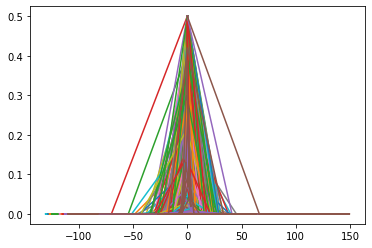

In [21]:
# plot Laplacian probability density function in a graph
from scipy.stats import laplace
import numpy as np
import matplotlib.pyplot as plt

# plot axis (x, y)
plt.plot(error, laplace.pdf(error))
plt.show()

In [0]:
# Lloyd-Max algorithm, where a total of 100 iterations are set to find optimal decision boundaries

import numpy as np
from scipy.stats import norm
from scipy import integrate

def cluster(x, levels, mean, variance, max_iter=100):
    """
    This routine clusters the positive portion of the Gaussian PDF of given mean
    and variance into required number of levels using an iterative update routine.
    The output is an array of converged cluster centroids.
    """
    max_int = 10 * variance  # p-Value ~ 1 (< 1e-12)
    intervals = np.linspace(0., max_int, levels + 1)
    centroids = np.zeros(levels)
    intervals[levels] = max_int
    thresh = 1e-5  

    # while (update > thresh):
    for i in range(max_iter):
        intervals_prev = np.copy(intervals)
        for j in range(levels):
            centroids[j] = integrate.quad(lambda x: x * norm.pdf(x, mean, variance**0.5), intervals[j], intervals[
                j + 1])[0] / integrate.quad(lambda x: norm.pdf(x, mean, variance**0.5), intervals[j], intervals[j + 1])[0]

        for j in range(levels - 1):
            intervals[j + 1] = (centroids[j + 1] + centroids[j]) / 2.

        if (np.linalg.norm(intervals_prev - intervals) < thresh):
            break

    return intervals, centroids

# set number of levels to 64
mean = 0
variance = 4
num_levels = 64

[intervals, clusters] = cluster(error, 32, mean, variance)
clusters = np.append(clusters, -1*clusters)
clusters = np.sort(clusters)

intervals = np.append(intervals, -1*intervals)
intervals = np.unique(intervals)

In [0]:
low_bound = intervals[0:-1]
top_bound = intervals[1:]

In [24]:
# print optimal decision boundaries and the central values
header = "Level \t d_{i-1} \t\t\t\t\t\t d_i \t\t\t\t\t\t r_i \n"
print(header)
with open("boundaries.txt",'w') as f:
  f.write(header)
  for i in range (1, intervals.shape[0]):    
    bound = "%s \t %s \t %s \t %s \n" % (i, low_bound[i-1], top_bound[i-1], clusters[i-1])
    print(bound)
    f.write(bound)
f.close()

Level 	 d_{i-1} 						 d_i 						 r_i 

1 	 -40.0 	 -14.57311992735942 	 -14.901777179977342 

2 	 -14.57311992735942 	 -13.981717448622739 	 -14.244462674741497 

3 	 -13.981717448622739 	 -13.472421828236415 	 -13.71897222250398 

4 	 -13.472421828236415 	 -12.98434091161962 	 -13.22587143396885 

5 	 -12.98434091161962 	 -12.503324691284295 	 -12.74281038927039 

6 	 -12.503324691284295 	 -12.025549429160428 	 -12.263838993298199 

7 	 -12.025549429160428 	 -11.549898090423172 	 -11.787259865022657 

8 	 -11.549898090423172 	 -11.075995419224578 	 -11.312536315823687 

9 	 -11.075995419224578 	 -10.603673536667447 	 -10.839454522625468 

10 	 -10.603673536667447 	 -10.132824409817074 	 -10.367892550709426 

11 	 -10.132824409817074 	 -9.663358848688276 	 -9.897756268924722 

12 	 -9.663358848688276 	 -9.195194980863466 	 -9.42896142845183 

13 	 -9.195194980863466 	 -8.728254897754393 	 -8.961428533275102 

14 	 -8.728254897754393 	 -8.262463573134529 	 -8.495081262233686 

15 	 -8.

In [0]:
def quant(mat):
  quantize = np.zeros(error.shape)
  for i in range(0, error.shape[0]):
    for j in range(0, error.shape[1]):
      # print(i,j)
      for n in range(0, low_bound.shape[0]):
        # print(n)
        if (top_bound[n] > mat[i][j] and mat[i][j] > low_bound[n]):
          # print(low_bound[n], error[i][j], top_bound[n], clusters[n])
          quantize[i][j] = clusters[n]
        else:
          pass
  return quantize

In [28]:
# Huffman coding
from heapq import heappush, heappop, heapify
from collections import defaultdict
 
def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""    
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
 
symb2freq = defaultdict(np.ndarray)
for i in range(0, laplace.pdf(error).shape[0]-1):
  for j in range(0, laplace.pdf(error).shape[1]-1):
    for n in range(0, low_bound.shape[0]):
      symb2freq[n] +=1
#     symb2freq[i] += 1
# txt = "Huffman coding testing"
# symb2freq = defaultdict(int)
# for symbol in txt:
#     symb2freq[symbol] += 1
huff = encode(clusters)
print("Symbol\tWeight\tHuffman Code")
for p in huff:
    print ("%s\t%s\t%s" % (p[0], symb2freq[p[0]], p[1]))

TypeError: ignored

In [0]:
quantized = quant(error)

In [0]:
import numpy as np

def reconstruct(A, q_error):   
  B = np.zeros(A.shape)
  N1, N2 = A.shape[0]-1, A.shape[1]-1

  for i in range (1, A.shape[0]):
    for j in range (1, A.shape[1]):           
      # g^*(i, 0) = g(i, 0)
      B[0:A.shape[0], 0] = A[0:A.shape[0], 0]
      # g^*(0, j) = g(0, j)
      B[0, 0:A.shape[1]] = A[0, 0:A.shape[1]]
      # add image with quantized error to get quantized errors in specific pixels
      B[0:255, 0:255] = q_error[0:255, 0:255] + B[0:255, 0:255] 

      # add quantized error in specific pixel[i][j] with raster scan pixels around pixel [i][j]
      # columns 2-255
      if (i<255):
        B[i][j] = (B[i][j-1] + B[i-1][j-1] + B[i][j-1] + B[i+1][j-1])/4 + B[i][j]
      # final column 256
      else:
        B[i][j] = (B[254][j-1] + B[254][j] + B[255][j-1])/3 + B[i][j]
      
  return B

In [31]:
# reconstruct the image by passing original image to reconstruct with quantized error
final = reconstruct(image, quantized)
# save the image
cv2.imwrite("final.jpg", final)

True

In [32]:
# calculate PSNR between original and reconstructed image
import cv2

original = cv2.imread("grayscale.jpg")
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
recons = cv2.imread("final.jpg")
recons = cv2.cvtColor(recons, cv2.COLOR_BGR2GRAY)
psnr = cv2.PSNR(original, recons)

print(psnr)

7.46346039658894


In [33]:
# second final image by using direct addition
final1 = prediction + quantized
cv2.imwrite("final1.jpg", final1)

True

In [34]:
# calculate PSNR between original and reconstructed image
import cv2

original = cv2.imread("grayscale.jpg")
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
recons = cv2.imread("final1.jpg")
recons = cv2.cvtColor(recons, cv2.COLOR_BGR2GRAY)
psnr = cv2.PSNR(original, recons)

print(psnr)

15.093807899001705
